# <center> Lecture15 : Hierarchical Models (2)</center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## bambi code  

【新增补充内容放到这个下面：复制即可】

### 补充内容：分层模型中的组层面预测因子(group-level predictors)

🤔 在上面的例子中，我们考虑了个体压力对于自我控制的影响，也考虑了不同站点对于自我控制的影响。然而，我们是否考虑过不同站点的其他特性对于自我控制的影响呢？ 
* 例如，不同站点对应了不同国家和地区，这些地区的经济发展水平、教育水平、人口结构等特性是否会对自我控制产生影响呢？




**例如，我们假设：地区(站点)经济水平越发达，个体自我控制能力越强**

组层面预测因子(group-level predictors)是指在组间(站点)层面的特征，这是相对于组内预测因子(group-level predictors)而言的。
* 例如，个体压力分数(stress)是组内预测因子。这个值在不同个体间具有不同值。
* 而地区的经济发展水平(GDP)是组层面预测因子。这些值在不同站点(site)间不同，但是在站点内的个体间保持相同。

![Image Name](https://cdn.kesci.com/upload/s5v47lfq02.png?imageView2/0/w/750/h/750)


In [ ]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')
# 选取所需站点
first5_site = ['Southampton','Portugal','Kassel','Tsinghua','UCSB']
df_first5 = df_raw.query("Site in @first5_site")
# 生成站点索引
df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]
# 生成被试数索引
df_first5["obs_id"] = range(len(df_first5))
# 计算站点平均湿度
df_first5['avg_mintemp'] = df_first5.groupby("Site").mintemp.transform('mean')
avg_mintemp = df_first5.groupby("Site").mintemp.mean()
# 将站点、被试id设置为索引
df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)
df_first5=df_first5[["avg_mintemp","stress","scontrol"]]

In [ ]:
df_first5

avg_mintemp  stress  scontrol
Site   obs_id                               
Kassel 0          3.712766      30        47
       1          3.712766      30        44
       2          3.712766      31        47
       3          3.712766      47        37
       4          3.712766      50        33
...                    ...     ...       ...
UCSB   410        9.603909      48        36
       411        9.603909      45        32
       412        9.603909      27        40
       413        9.603909      46        31
       414        9.603909      30        48

[415 rows x 3 columns]

由于我们只考虑了我个站点的数据，因此平均站点的最低气温也只有5个数据点。

* 为了可视化平均最低气温对自我控制的影响，我们需要对自我控制分数进行各站点的平均，然后绘制回归曲线。
* 可以看到，温度越高，自我控制的分数越高。

In [ ]:
df_first5.groupby("Site").mean()

,avg_mintemp,stress,scontrol
Site,,,
Kassel,3.712766,39.679245,41.339623
Portugal,12.111111,38.047619,46.095238
Southampton,4.333333,39.833333,38.666667
Tsinghua,13.735632,39.833333,39.477011
UCSB,9.603909,41.925926,38.574074


<Axes: xlabel='avg_mintemp', ylabel='scontrol'>

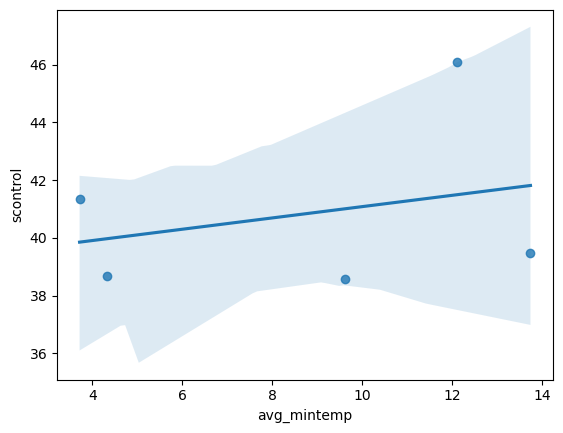

In [ ]:
sns.regplot(x="avg_mintemp", y="scontrol", data=df_first5.groupby("Site").mean())

**构建具有组层面预测因子的分层模型**

回顾之前的仅包含变化的截距的分层模型：

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(Layer1: 每个站点内的线性模型)} \\  
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(Layer2: 截距在站点间的变化)} \\  
\beta_{0}  & \sim N(0, 50^2) & \text{(Layer3: 全局参数的先验)} \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_0 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$

🤔 如果我们想考虑组层面预测因子GDP，那么该变量该放在哪个层呐(Layer)？
* 由于组层面预测因子是组间(站点$j$)层面的特征，因此该变量主要影响截距在站点间的变化。
* 公式写作： $\beta_{0j} = \gamma_0 + \gamma_1 U_j$
  * 其中，$U_j$是站点$j$的组层面预测因子
  * $\gamma_1$是组层面预测因子$U_j$的回归系数；而$\gamma_0$为站点间的变化的截距。
  * 因此，每个站点的截距 $\beta_{0j}$，受到组层面的预测因子$U_j$的影响。
* 也可以写作 $\mu_{ij} = \beta_{0j} + \beta_1 X_{ij} = (\gamma_0 + \gamma_1 U_j) + \beta_1 X_{ij}$

**总的公式** 

将 $\beta_{0j} = \gamma_0 + \gamma1 U_j$ 放入之前的公式，并且为新参数$\gamma_0$和$\gamma_1$引入先验分布：

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(Layer1: 每个站点内的线性模型)} \\  
\beta_{0j} | \gamma_0, \gamma_1, \sigma_0  & \stackrel{ind}{\sim} N(\gamma_0 + \gamma_1 U_j, \sigma_0^2) & \text{(Layer2: 截距在站点间的变化)} \\  
\gamma_0  & \sim N(0, 50^2) & \text{(Layer3: 全局参数的先验)} \\  
\gamma_1 & \sim N(0, 5^2) & \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_0 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$

**总的公式: 另一种定义形式** 

我们也可以进一步将 $\beta_{0j} = \gamma_0 + \gamma1 U_j$ 放入之 $\mu_{ij} = \beta_{0j} + \beta_1 X_{ij}$中，此时 $\mu_{ij} = \beta_{0j} + \beta_1 X_{ij} + \gamma_1 U_{j}$：

$$  
\begin{array}{rll}  
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} + \gamma_1 U_{j}& \text{(Layer1: 每个站点内的线性模型)} \\  
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(Layer2: 截距在站点间的变化)} \\  
\beta_0  & \sim N(0, 50^2) & \text{(Layer3: 全局参数的先验)} \\  
\gamma_1 & \sim N(0, 5^2) & \\  
\beta_1  & \sim N(0, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_0 & \sim \text{Exp}(1).    & \\  
\end{array}  
$$

* 需要注意的是，该定义方式为 Bambi 默认定义方式
* 此时，$\gamma_0$ 变为 $\beta_0$, 这和之前的仅包含变化截距的分层模型一样。 

In [ ]:
# PyMC 代码示例

#定义数据坐标，包括站点和观测索引
coords = {"site": df_first5["Site"].unique(),
        "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as group_pred_model:
    #定义全局参数
    gamma_0 = pm.Normal("beta_0", mu=0, sigma=50)
    gamma_1 = pm.Normal("gamma_1", mu=0, sigma=5) 
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5) 
    sigma_y = pm.Exponential("sigma_y", 1) 
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)

    #传入自变量、获得观测值对应的站点映射
    x = pm.MutableData("x", df_first5.stress, dims="obs_id")
    u = pm.MutableData("u", avg_mintemp, dims="site")
    site_idx = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

    #定义组层面变量
    beta_0j = pm.Normal("beta_0j", mu=gamma_0+gamma_1*u, sigma=beta_0_sigma, dims="site")

    #线性关系
    mu = pm.Deterministic("mu", beta_0j[site_idx]+beta_1*x, dims="obs_id")

    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

    group_pred_trace = pm.sample(draws=5000,           # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                     # 链数
                        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                        random_seed=84735,
                        target_accept=0.99)

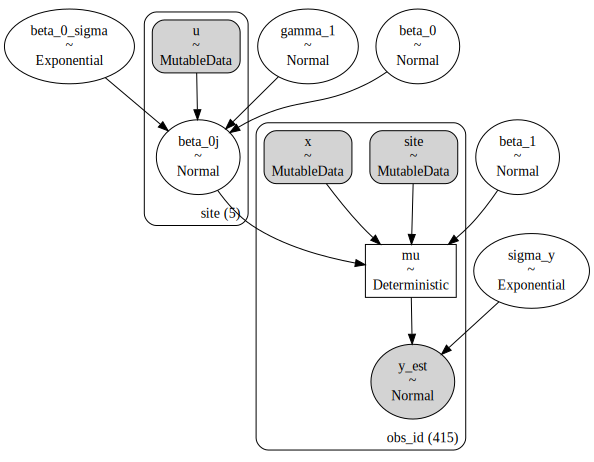

In [ ]:
pm.model_to_graphviz(group_pred_model)

当模型变得复杂， 在 PyMC 中定义分层模型将变得困难。

使用 Bambi 可以轻松定义以上模型，其模型定义公式为 `"scontrol ~ 1 + GDP + stress + (1|Site)"`
* 可以发现，在 Bambi 中，组层面的预测因子(GDP)的定义方式和个体层面的预测因子(stress)的定义方式一致。
* 也就是说，Bambi 支持用同一种公式定义个体和组层面的预测因子。

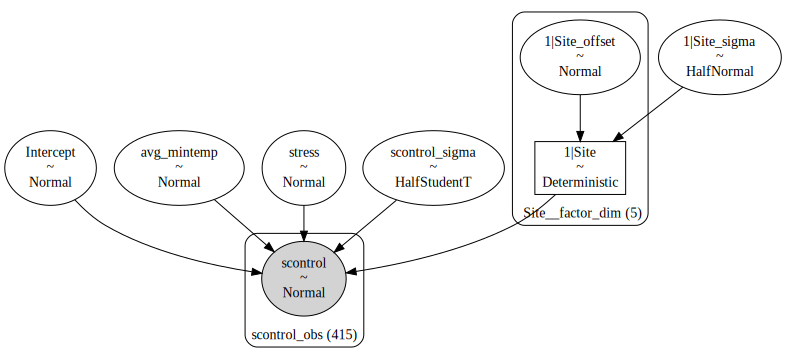

In [ ]:
group_pred_bmb = bmb.Model("scontrol ~ stress + avg_mintemp + (1|Site)",
                      df_first5,
                      categorical="Site")

group_pred_bmb.build()
group_pred_bmb.graph()

###  MCMC采样&后验参数估计  

* 可以看到组层面预测因子(平均最低气温)的回归斜率$\gamma_{1j}$和截距$\gamma_{0j}

In [ ]:
az.summary(group_pred_trace,
           var_names=["j","gamma_0","gamma_1","beta_1","~offset","~mu"],
           filter_vars="like")

### 后验预测回归线

* 下面展示了组层面预测因子(平均最低气温)的回归预测结果

In [ ]:
# 提取原始数据，每一个因变量的后验预测均值
u = trace.constant_data.u.values
y = trace.observed_data.y_est.values.group("Site").mean()
# 提取组层面回归参数: beta_0j = gamma_0 + gamma_1 * u
beta_0j = trace.posterior.beta_0j.values
# 绘制原始数据
plt.scatter(u, y,
        color="black",
        alpha=0.5)
#绘制回归线
plt.plot(u, beta_0j.stack(sample=("chain","draw")).mean(dim="sample"),
        color=f"red",
        alpha=0.5)
#绘制预测值95%HDI
az.plot_hdi(
        u, beta_0j,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.25, "linewidth": 0},
        color=f"orange",
        ax=ax[i])
# 生成横坐标名称
fig.text(0.5, 0, 'avg_mintemp', ha='center', va='center', fontsize=12)
# 生成纵坐标名称
fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
# 生成标题
plt.suptitle("Posterior regression models", fontsize=15)

sns.despine()

## Hierarchical logistic regression

> 在之前的课程中，除了正态回归模型，我们还介绍过logistic回归模型、泊松回归模型和负二项回归模型。这些模型同样可以和层级模型结合  

* 在lec13中我们使用回避依恋分数来预测个体的恋爱情况，假设这一线性关系在不同文化中有不同的表现，我们也可以把站点信息考虑在内  

* 对于因变量为离散变量的情况，我们需要使用广义线性模型(Generalized linear model，GLM)。  

* 其特点为：  
	- 分布簇 (dist)不再局限于正态分布，而是允许其他不同的分布，比如 $y \sim Bernoulli(p)$  
	- 需要 **链接函数$g()$** 将 $\alpha + \beta * x$  映射到 $p$所在的范围  

| 一般线性模型 | 广义线性模型 |  
|---|---|  
| $y \sim Normal(\mu, \sigma)$ | $y \sim dist(p)$ |  
| $\mu = \alpha + \beta *x$ | $p = g(z)$|  
|  | $z = \alpha + \beta *x$|  


### 层级模型  

$$  

\begin{array}{rll}  
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0j} + \beta_{1j} X_{ij}}}{1 + e^{\beta_{0j} + \beta_{1j} X_{ij}}} \\  
&& \text{(每个站点 $j$内的线性模型)}\\  
\beta_{0j} | \beta_0, \sigma_0    & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\  
\beta_{1j} | \beta_1, \sigma_1    & \stackrel{ind}{\sim} N(\beta_1, \sigma_1^2) & \text{(斜率在站点间的变化)} \\  
\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\  
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\  
\sigma_0 & \sim \text{Exp}(1). & \\  
\sigma_1 & \sim \text{Exp}(1). & \\  
\end{array}  

$$